# Question One
Management is trying to better understand what is happening at these food marts. To that end, please create some visualizations to help us better understand the following dimensions of the Foodmart data:
- Category of products sold
- Brand of products sold

From a business standpoint, supermarkets exist to make money from the food they sell. So it's useful to know which types of products are driving profit. My data visualizations with focus the profitability of product categories and brands.

In [217]:
from os import environ
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [292]:
# Load cleaned datasets into DataFrame from Make through env variables.
dataset_paths = ['../' + dataset for dataset in environ['datasets'].split()]
product, product_class, promotion, transactions = [pd.read_pickle(path) for path in dataset_paths]


## Which product categories are the most profitable?

Let's start by finding the gross profit of every transaction - how much money was made on the transaction after the cost of the goods is deducted.

To compute _total gross profit_, we must first join transaction to products and product classes.

In [219]:
trans_prod = pd.merge(transactions, product, on='product_id', how='inner')
trans_prod_class = pd.merge(trans_prod, product_class, on='product_class_id', how='inner')

Then, we find the gross profit of each transaction by subtracting its sales revenue from its sales cost.

In [220]:
trans_prod_class['gross_profit'] = trans_prod_class['store_sales'] - trans_prod_class['store_cost']

Now, let's sum up those product-level profits by product category, so we can see which categories were the most profitable for Foodmart in 1997.

In [221]:
profit_by_category = trans_prod_class.groupby('product_category')['gross_profit'].sum()

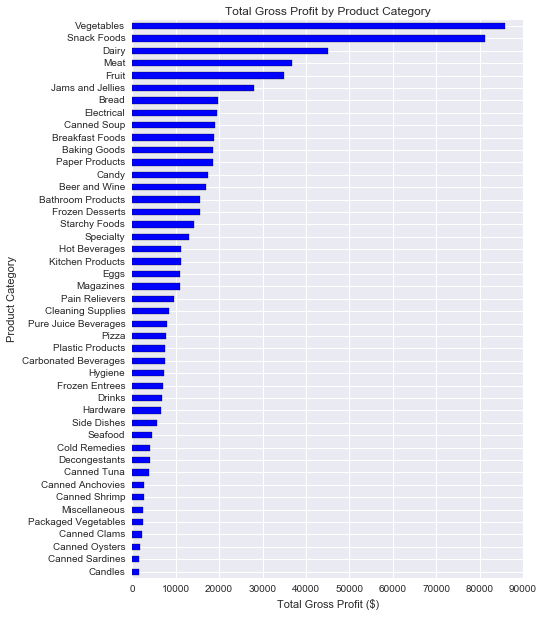

In [293]:
# Plot vertical barchart of profits by category, in descending order.
plt.figure(figsize=(7,10))
profit_by_category.sort_values().plot(kind='barh')
plt.title('Total Gross Profit by Product Category')
plt.xlabel('Total Gross Profit ($)')
plt.ylabel('Product Category')
plt.savefig('total_profit_by_product_category.png', bbox_inches='tight')

## Profit Drivers - Units Sold and Profit Margins

What's driving certain products to be more profitable than others? Maybe the most profitable products are simply the ones that sell the most. Or maybe they're the ones with the highest profit margins.

To discover our profit drivers, let's take a look at profitability against sales rates and profit margin. Sales rates and profit margins aren't in the original data, so we must define measures of these concepts, and use them to construct new variables.

First, we measure the _profitability_ of products by computing the total gross profit Foodmart made on each product in 1997:

In [223]:
total_profit_by_product = trans_prod_class.groupby('product_id')['gross_profit'].sum().reset_index()

Next, we need to compute the _sales rate_ of each product. We'll keep it simple and look at the number of units sold per month, by product.

In [224]:
units_sold_by_product = trans_prod_class.groupby('product_id')['unit_sales'].sum().reset_index()

Finally, we want to measure the _profit per unit_ of each product.

To do so, we first calculate the gross profit per unit sold within each transaction - how much money did the store keep for every product sold in a transaction? (Recall that a transaction is one or more identical products with a fixed cost and sales price.)

In [225]:
trans_prod_class['gross_profit_per_unit'] = trans_prod_class['gross_profit'] / trans_prod_class['unit_sales']

Due to promotions, which vary the sales price of a product from day to day, products may have several profit per unit figures associated with them. We need a single product-level profit per unit metric, so let's take the mean for each product:


In [226]:
mean_unit_profit_by_product = trans_prod_class.groupby('product_id')['gross_profit_per_unit'] \
                                              .mean() \
                                              .reset_index() \
                                              .rename(columns={'gross_profit_per_unit': 'mean_profit_per_unit'})

Let's take a look at the resulting distribution of _mean profit per unit_ for products:

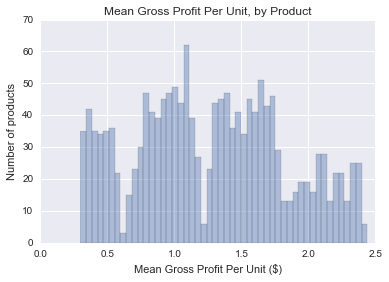

In [251]:
sns.distplot(mean_unit_profit_by_product['mean_profit_per_unit'], bins=50, kde=False)
plt.xlabel('Mean Gross Profit Per Unit ($)')
plt.ylabel('Number of products')
plt.title('Mean Gross Profit Per Unit, by Product')

Products appear to fall into one of four "profit margin buckets" - low, medium, high, and vey high.

Let's join our new product-level measures together.

In [228]:
# Join total profits per product to average unit profit to units sold by product.
products_profit_measures = pd.merge(mean_unit_profit_by_product, total_profit_by_product, on='product_id')
products_profit_measures = pd.merge(products_profit_measures, units_sold_by_product, on='product_id')

And let's join the measures to our `product` and `product_class` tables, so we can aggregate our new measure in terms of product categories.

In [229]:
products_profits = pd.merge(products_profit_measures, product, on='product_id')
products_profits = pd.merge(products_profits, product_class, on='product_class_id')

Now let's find the total gross profit and mean product profit per unit by product category. In other
words:
1. How much profit did Foodmart make in total, from all the products in this category?
2. On average, how much money did Foodmart make when they sold a single unit of the products in this category?

In [230]:
categories_profit = products_profits.groupby('product_category') \
                                    .agg({'mean_profit_per_unit': np.mean, 'gross_profit': np.sum, 'unit_sales': np.sum}) \
                                    .reset_index() \
                                    .rename(columns={'mean_profit_per_unit':'mean_product_profit_per_unit',
                                                     'gross_profit':'total_gross_profit',
                                                     'unit_sales':'total_unit_sales'})

We're finally ready to examine drivers of profit for product categories.

We should expect the single biggest driver to be... the number of product units that sold. Let's check whether this is true.

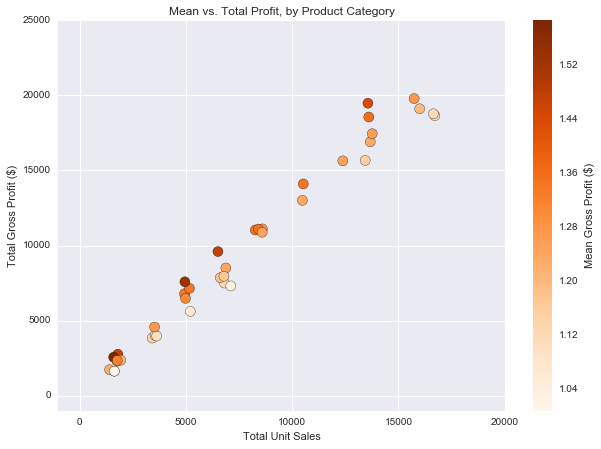

In [294]:
plt.figure(figsize=(10,7))
plt.scatter(categories_profit['total_unit_sales'], # X variable
            categories_profit['total_gross_profit'],  # Y variable
            c=categories_profit['mean_product_profit_per_unit'], # Z variable - dot color
            cmap=plt.cm.Oranges,  # color ramp to use for dots
            s=100)  # Size of each dot

plt.xlim((-1000,20000))
plt.ylim((-1000,25000))
plt.xlabel('Total Unit Sales')
plt.ylabel('Total Gross Profit ($)')
plt.title('Mean vs. Total Profit, by Product Category')
plt.colorbar().set_label('Mean Gross Profit ($)')
plt.savefig('mean_vs_total_profit_by_product_category.png', bbox_inches='tight')

Unsurprisingly, total units sales are very highly correlated with total profits for a product category. 

The color of the dots represent the mean profit per unit, and reveal another, smaller source of variation: for a given number of unit sales, product categories with a higher mean profit per unit tended to be more profitable.

Not an earth shattering insight, perhaps, but this raises our confidence level the quality of our data.


Let's go deeper into mean profit next, by looking at the distribution of mean product profit per unit by product category:

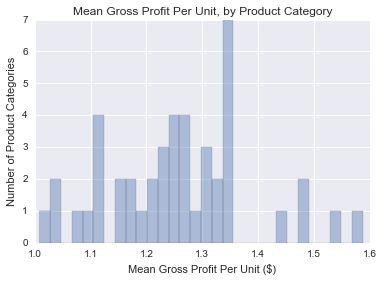

In [286]:
sns.distplot(categories_profit['mean_product_profit_per_unit'], bins=30, kde=False)
plt.xlabel('Mean Gross Profit Per Unit ($)')
plt.ylabel('Number of Product Categories')
plt.title('Mean Gross Profit Per Unit, by Product Category')

At the product category level, average profit margins range from \$1.00 to \$1.60 per unit. Most categories fall between \$1.15 and \$1.35. This is why grocers complain about razor-thin margins!

Let's see how the variation in mean profit margin is associated with total profits:

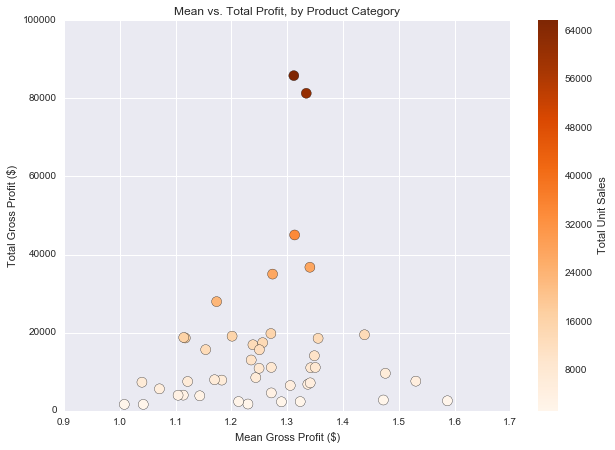

In [245]:
plt.figure(figsize=(10,7))
plt.scatter(categories_profit['mean_product_profit_per_unit'], # X variable
            categories_profit['total_gross_profit'],  # Y variable
            c=categories_profit['total_unit_sales'], # Z variable - dot color
            cmap=plt.cm.Oranges,  # color ramp to use for dots
            s=100)  # Size of each dot

plt.ylim((0,100000))
plt.xlabel('Mean Gross Profit ($)')
plt.ylabel('Total Gross Profit ($)')
plt.title('Mean vs. Total Profit, by Product Category')
plt.colorbar().set_label('Total Unit Sales')

This is interesting. While total unit sales (represented by the shade of the dots in this chart) are still the dominant factor behind profits, the high-profit categories tend to have profit margins around $1.30 per unit - not low, and not too high.

By assigning categories to "profit buckets" based on their the mean profit per unit of their products, we can drill down further.

In [264]:
def profit_to_buckets(s):
    '''Map a profit figure to a margin bucket.'''
    if s < 1.15:
        return 'low'
    elif s >= 1.15 and s < 1.25:
        return 'medium'
    elif s >= 1.25 and s < 1.35:
        return 'high'
    else:
        return 'very high'

In [257]:
# Create a new profit bucket categorical variable based on mean unit profit of each category.
# Profit bucket cutoffs are guided by the histogram of mean unit profit.
categories_profit['profit_bucket'] = categories_profit['mean_product_profit_per_unit'].sort_values().map(profit_to_buckets)

What percentage of categoreis fall in each bucket?

In [265]:
categories_profit.profit_bucket.value_counts() / categories_profit.shape[0]

high         0.377778
medium       0.244444
low          0.222222
very high    0.155556
Name: profit_bucket, dtype: float64

24% of product categories have medium margins, while 37% have high margins.

In [266]:
categories_profit[categories_profit.total_gross_profit > 1000].profit_bucket.value_counts()

high         17
medium       11
low          10
very high     7
Name: profit_bucket, dtype: int64

Now, we can look at the profitability of each category based on the profit bucket it sits in:

In [267]:
def make_product_profit_bucket_subplot(df, column, profit_bucket, bucket_label, ax):
    df.set_index(column)['total_gross_profit'].sort_values().plot(kind='barh', ax=ax)
    ax.set_title(profit_bucket + ' margin - ' + bucket_label)
    ax.set_ylabel('') # Avoid adding a y label to every subplot
    ax.set_xlabel('Average Total Gross Profit ($)')

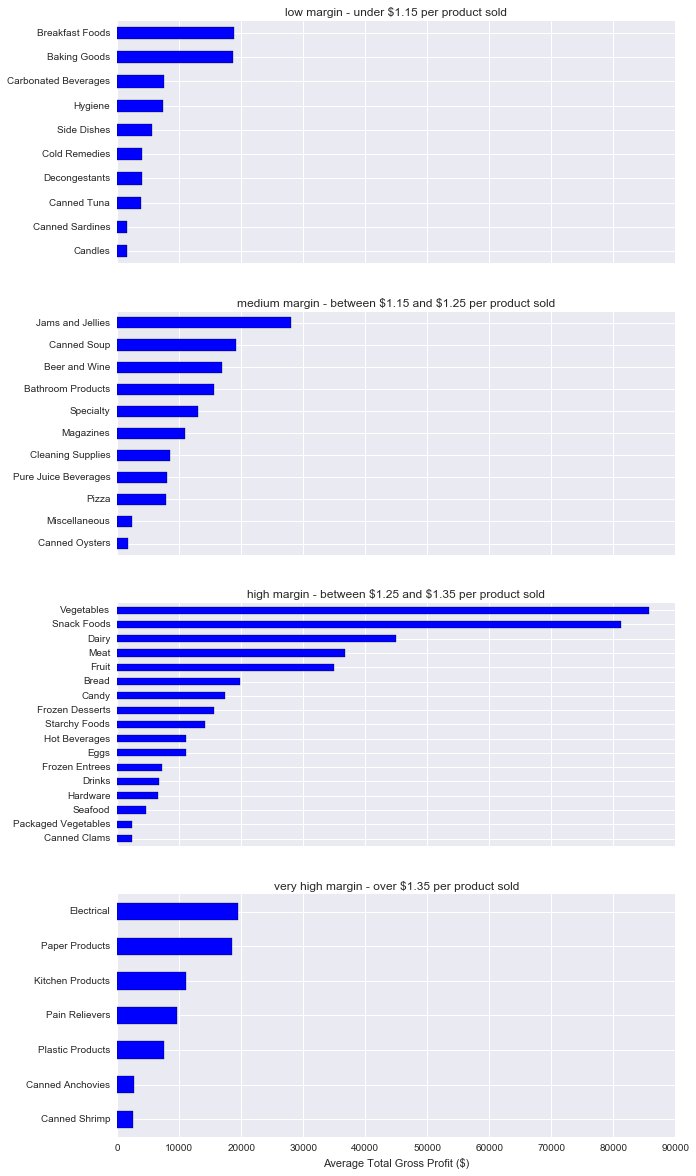

In [270]:
f, axes = plt.subplots(4, sharex=True, figsize=(10,20))
profit_margin_buckets = ['low', 'medium', 'high', 'very high']
bucket_labels = ['under $1.15 per product sold', 
                 'between \$1.15 and \$1.25 per product sold', 
                 'between \$1.25 and \$1.35 per product sold', 
                 'over $1.35 per product sold']
for ix, ax in enumerate(axes):
    profit_bucket = profit_margin_buckets[ix]
    bucket_label = bucket_labels[ix]
    category_bucket = categories_profit[categories_profit['profit_bucket'] == profit_bucket]  # Subset categories by profit bucket
    make_product_profit_bucket_subplot(category_bucket, 'product_category', profit_bucket, bucket_label, ax)
plt.savefig('product_category_profit_by_margin.png', bbox_inches='tight')

- The most profitable are Vegetables, Snack Food, Dairy, Meat and Fruit. They brought in over \$30,000 in profit over the course of 1997 (keep in mind, these numbers are small because we're likely working with a small sample of transactions.)
- 24% of product categories have medium margins, while 37% have high margins. Theree are relative few products at either end of the profit margin scale.
- Of the 5 products that made over $3,000 in gross profits, all of them are in the "high margin" category, not the "very high margin" category.
- Across all margin buckets, canned and prepared foods (canned shrimp, packaged vegtables, canned tuna) appear to be less profitable than fresh foods (eggs, dairy, beer).

Finally, we can add unit sales for a complete picture of each category:

In [299]:
def make_product_profit_bucket_scatterplot(df, column, profit_bucket, bucket_label, ax):
    df.plot(kind='scatter', x='total_unit_sales', y='total_gross_profit', ax=ax)    
    for ix, (prod_attr, x, y) in df[[column, 'total_unit_sales', 'total_gross_profit']].iterrows():
        ax.annotate(prod_attr, xy = (x, y), xytext = (np.random.uniform(-20,20), -12), textcoords='offset points', rotation=-45)

    ax.set_title(profit_bucket + ' margin - ' + bucket_label)
    ax.set_ylabel('') # Avoid adding a y lbel for each subplot
    ax.set_xlabel('Average Total Gross Profit ($)')

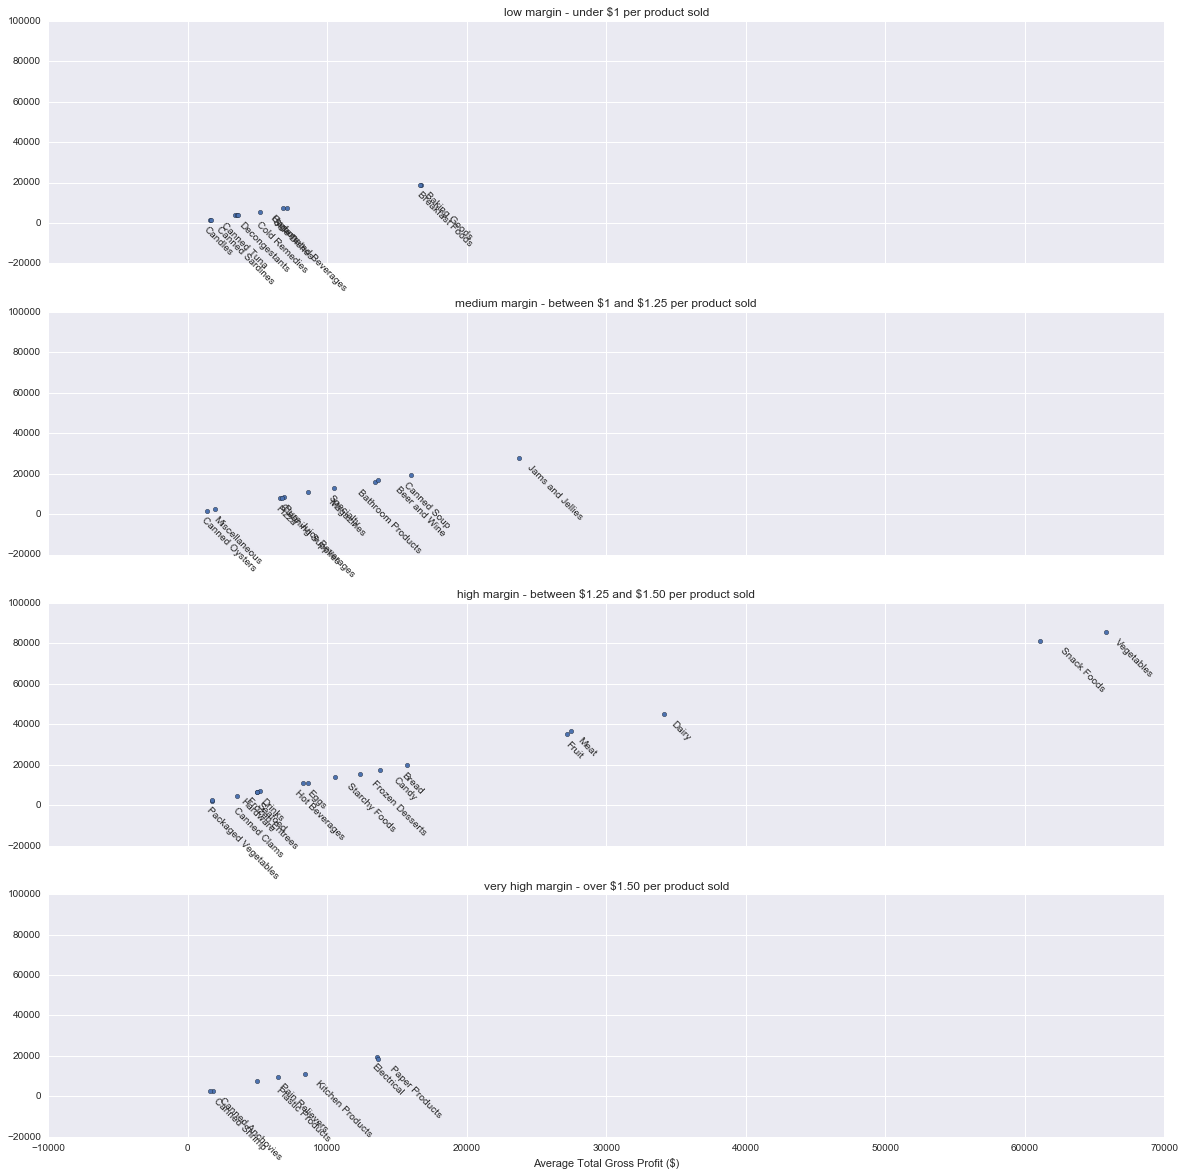

In [303]:
f, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(20,20))
profit_buckets = ['low', 'medium', 'high', 'very high']
bucket_labels = ['under $1 per product sold', 
                 'between \$1 and \$1.25 per product sold', 
                 'between \$1.25 and \$1.50 per product sold', 
                 'over $1.50 per product sold']
for ix, ax in enumerate(axes):
    profit_bucket = profit_buckets[ix]
    bucket_label = bucket_labels[ix]    
    category_bucket = categories_profit[categories_profit['profit_bucket' ] == profit_bucket]  # Subset categories by profit bucket
    make_product_profit_bucket_scatterplot(category_bucket, 'product_category', profit_bucket, bucket_label, ax)

## Which product brands are the most profitable?

To understand what drives profits for brands, let's give them the same treatment we gave to product categories.

First, compute total profits per brand:

In [273]:
profit_by_brand = trans_prod_class.groupby('brand_name')['gross_profit'].sum()

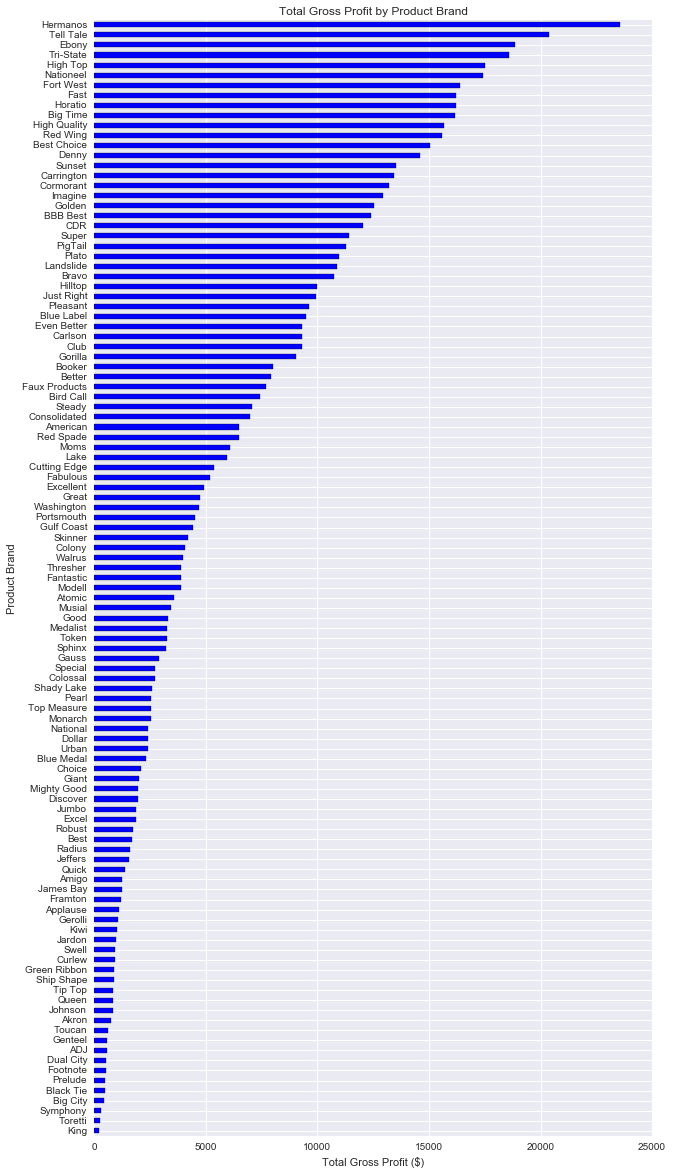

In [276]:
plt.figure(figsize=(10, 20))
profit_by_brand.sort_values().plot(kind='barh')
plt.title('Total Gross Profit by Product Brand')
plt.xlabel('Total Gross Profit ($)')
plt.ylabel('Product Brand')

There's are tons of brands, and without more domain knowledge, it's hard to tell much about them just by looking at them.

As before, let's compute total unit sales and mean profits per unit...

In [275]:
brands_profit = products_profits.groupby('brand_name') \
                                    .agg({'mean_profit_per_unit': np.mean, 'gross_profit': np.sum, 'unit_sales': np.sum}) \
                                    .reset_index() \
                                    .rename(columns={'mean_profit_per_unit':'mean_product_profit_per_unit',
                                                     'gross_profit':'total_gross_profit',
                                                     'unit_sales':'total_unit_sales'})

...and look at the relationship of unit sales and profits.

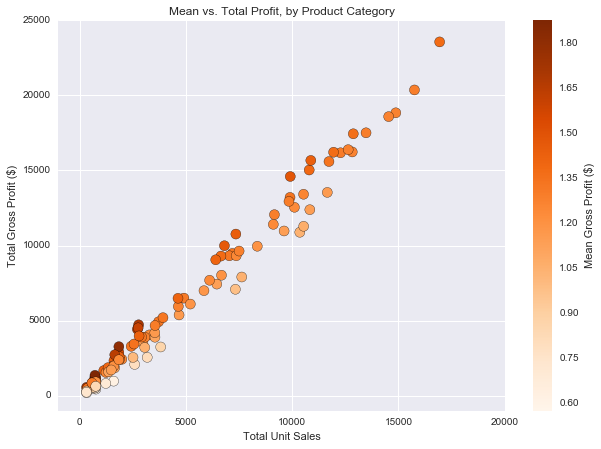

In [249]:
plt.figure(figsize=(10,7))
plt.scatter(brands_profit['total_unit_sales'], # X variable
            brands_profit['total_gross_profit'],  # Y variable
            c=brands_profit['mean_product_profit_per_unit'], # Z variable - dot color
            cmap=plt.cm.Oranges,  # color ramp to use for dots
            s=100)  # Size of each dot

plt.xlim((-1000,20000))
plt.ylim((-1000,25000))
plt.xlabel('Total Unit Sales')
plt.ylabel('Total Gross Profit ($)')
plt.title('Mean vs. Total Profit, by Product Category')
plt.colorbar().set_label('Mean Gross Profit ($)')

As expected, unit sales remains the key driver of profits.

Let's inspect the distribution of mean product profit per unit.

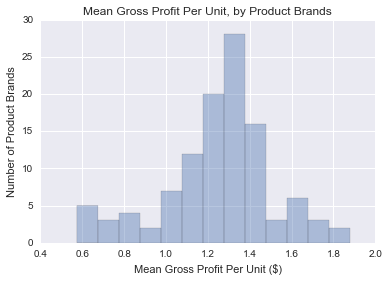

In [287]:
sns.distplot(brands_profit['mean_product_profit_per_unit'], kde=False)
plt.xlabel('Mean Gross Profit Per Unit ($)')
plt.ylabel('Number of Product Brands')
plt.title('Mean Gross Profit Per Unit, by Product Brands')

The distribution for brands has a wider range than the one for categories - from \$.6 to \$1.8. This makes sense, since grouping the products into more buckets is bound to produce some smaller averages.

Let's see to what extent this variance of mean profits explains the variance of total profits for brands:

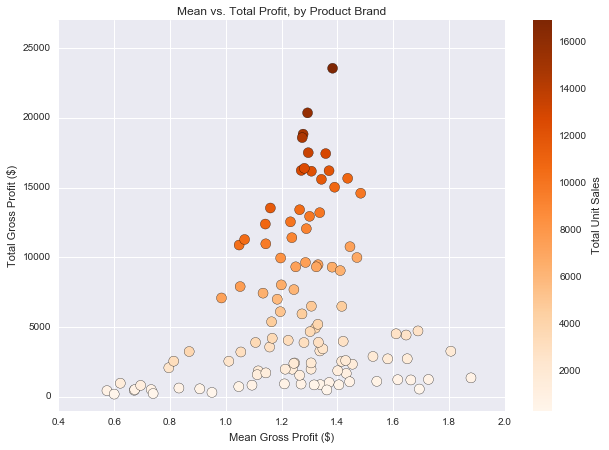

In [295]:
plt.figure(figsize=(10,7))
plt.scatter(brands_profit['mean_product_profit_per_unit'], # X variable
            brands_profit['total_gross_profit'],  # Y variable
            c=brands_profit['total_unit_sales'], # Z variable - dot color
            cmap=plt.cm.Oranges,  # color ramp to use for dots
            s=100)  # Size of each dot

plt.ylim((-1000,27000))
plt.xlabel('Mean Gross Profit ($)')
plt.ylabel('Total Gross Profit ($)')
plt.title('Mean vs. Total Profit, by Product Brand')
plt.colorbar().set_label('Total Unit Sales')
plt.savefig('mean_vs_total_profit_by_product_brand.png', bbox_inches='tight')

With more brands than product categories, the "sweet spot" of mean profit is even more pronounced - the brands that achieve high sales, and thus high profits, all have profit margins between \$1.20 and \$1.40.

Finally, let's make a data visualization that allow you to view the total profit of each brand, grouped by profit margin bucket.

In [282]:
def profit_to_buckets(s):
    if s < 1:
        return 'low'
    elif s >= 1 and s < 1.25:
        return 'medium'
    elif s >= 1.25 and s < 1.5:
        return 'high'
    else:
        return 'very high'


In [283]:
brands_profit['profit_bucket'] = brands_profit['mean_product_profit_per_unit'].sort_values().map(profit_to_buckets)

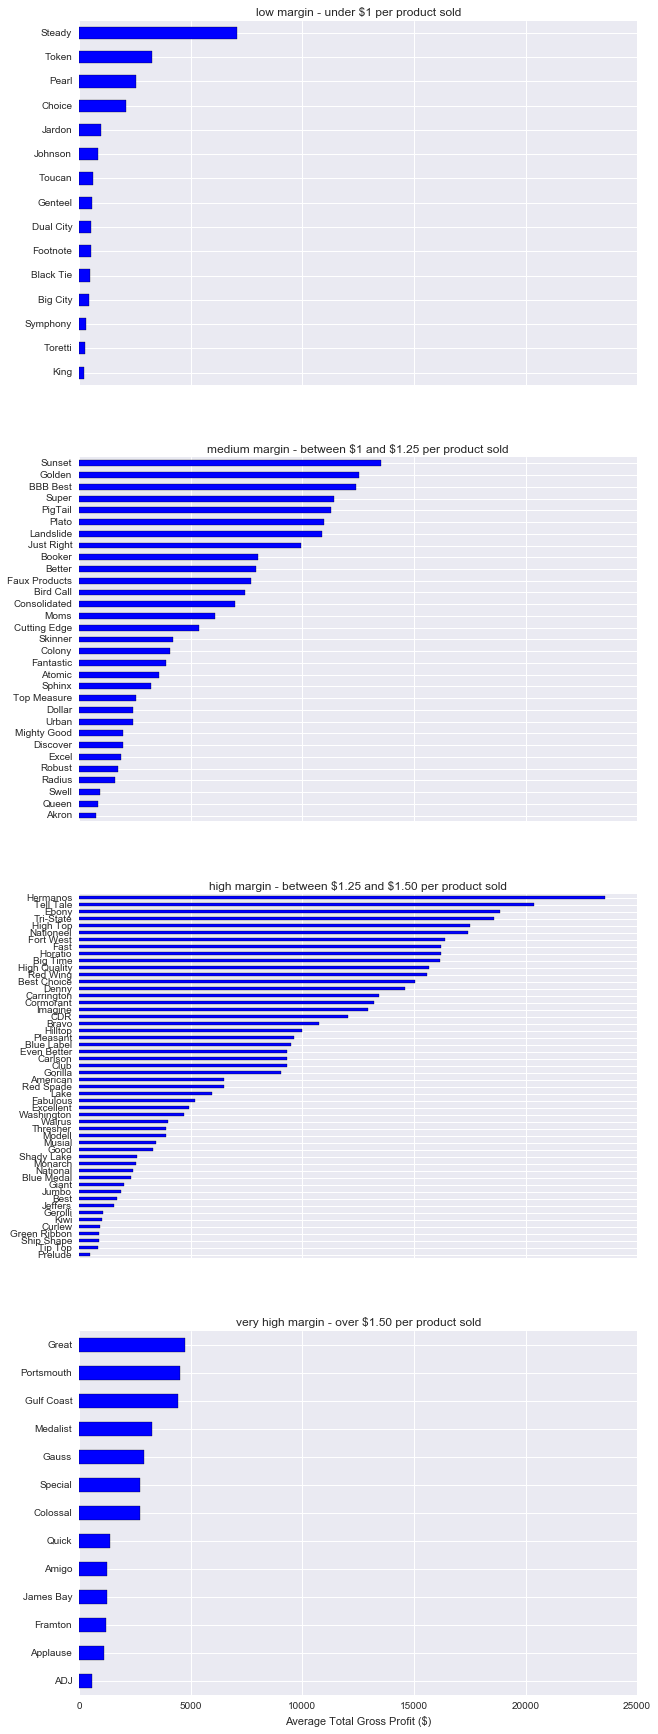

In [288]:
f, axes = plt.subplots(4, sharex=True, figsize=(10,30))
profit_margin_buckets = ['low', 'medium', 'high', 'very high']
bucket_labels = ['under $1 per product sold', 
                 'between \$1 and \$1.25 per product sold', 
                 'between \$1.25 and \$1.50 per product sold', 
                 'over $1.50 per product sold']
for ix, ax in enumerate(axes):
    profit_bucket = profit_margin_buckets[ix]
    bucket_label = bucket_labels[ix]
    brand_bucket = brands_profit[brands_profit['profit_bucket'] == profit_bucket]  # Subset brands by profit bucket
    make_product_profit_bucket_subplot(brand_bucket, 'brand_name', profit_bucket, bucket_label, ax)
plt.savefig('product_brand_profit_by_margin.png', bbox_inches='tight')


And let's try to add the unit sales dimension, to see if we can make the viz more informative.

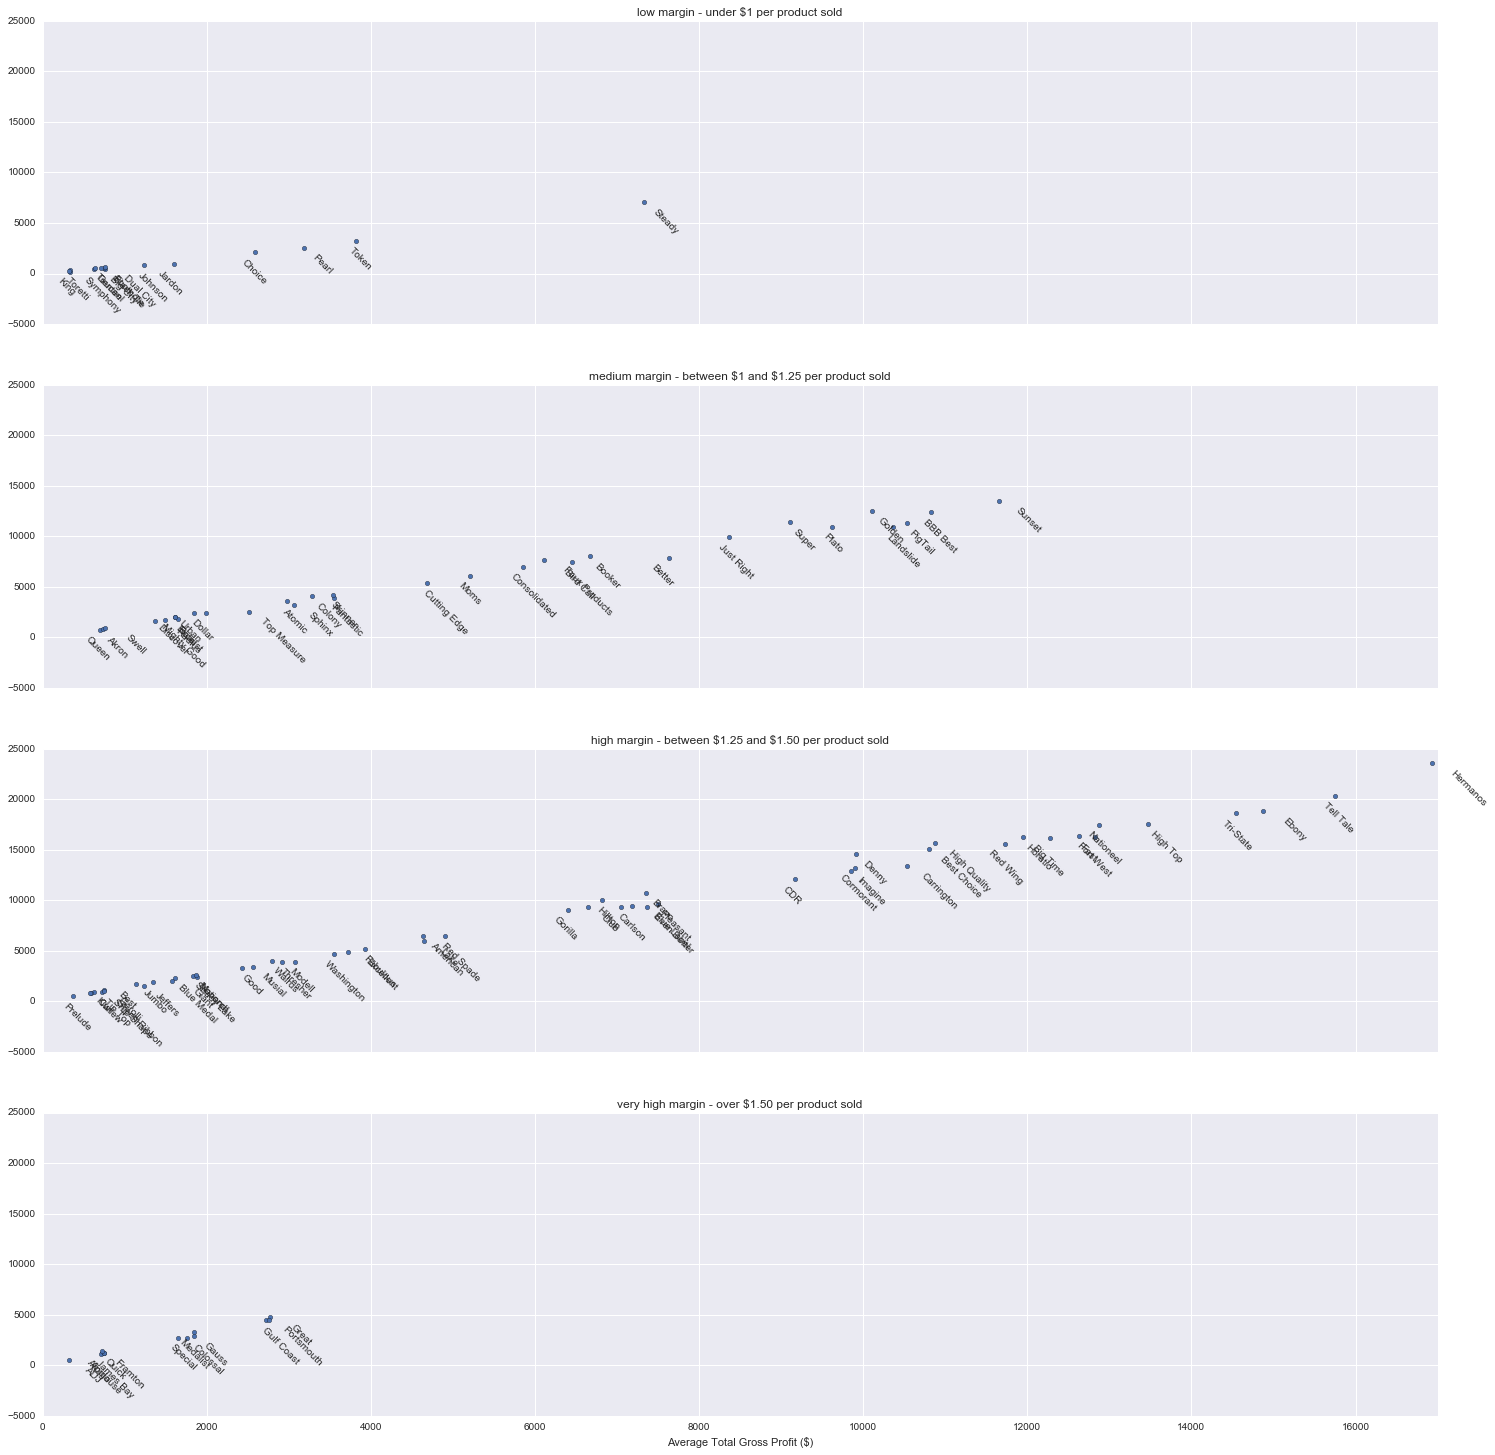

In [301]:
f, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(25,25))
profit_buckets = ['low', 'medium', 'high', 'very high']
bucket_labels = ['under $1 per product sold', 
                 'between \$1 and \$1.25 per product sold', 
                 'between \$1.25 and \$1.50 per product sold', 
                 'over $1.50 per product sold']
for ix, ax in enumerate(axes):
    profit_bucket = profit_buckets[ix]
    bucket_label = bucket_labels[ix]
    brand_bucket = brands_profit[brands_profit['profit_bucket'] == profit_bucket]  # Subset brands by profit bucket
    make_product_profit_bucket_scatterplot(brand_bucket, 'brand_name', profit_bucket, bucket_label, ax)

plt.xlim(0,17000)
plt.savefig('product_brand_sales_vs_profit_by_margin.png', bbox_inches='tight')